According to Matt's epxeriance ([link](https://github.com/goodarzilab/khorms/blob/master/side_projects/COVID_DMSseq_library.ipynb)) I'm using this genome:

- https://www.ncbi.nlm.nih.gov/nuccore/MN908947?%3Fdb=nucleotide


# Peaks
<img src="plots/peaks.png" style="height:400px">

# _N_ & _ORF10_
<img src="plots/N&ORF10.png" style="height:400px">


# _S_
<img src="plots/S.png" style="height:400px">

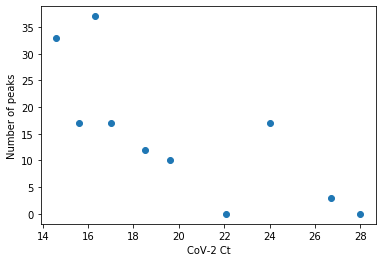

In [177]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

qPCR = pd.read_csv('RTqPCR.txt', sep='\t',index_col=0)
# create some x data and some integers for the y axis
x = np.array(qPCR.iloc[:,0])
y = np.array(qPCR.iloc[:,1], dtype=int)

# plot the data
# fig = plt.figure()
# plt.scatter(x, y)
# plt.xlabel('CoV-2 Ct', fontsize=10)
# plt.ylabel('Number of peaks', fontsize=10)
# fig.savefig('plots/Ct_vs_peak.pdf')
plt.scatter(x, y)
plt.xlabel('CoV-2 Ct', fontsize=10)
plt.ylabel('Number of peaks', fontsize=10)
plt.show()

# Motif analysis 

In [645]:
%%bash 
cat exomepeak/virus/S0085/S0085/peak.bed exomepeak/virus/S0008/S0008/peak.bed \
exomepeak/virus/S0009/S0009/peak.bed exomepeak/virus/S0014/S0014/peak.bed \
exomepeak/virus/S0026/S0026/peak.bed exomepeak/virus/S0030/S0030/peak.bed | grep -v '^ *#' | bed12ToBed6 | \
sort -k1,1 -k2,2n | mergeBed -i - -c 4 -o distinct | awk '{print $1"\t"$2"\t"$3"\t"$4"\t"".""\t""+"}' > lowCt_peaks.bed

bedtools getfasta -name -s -fi virus/coronavirus_2_isolate_Wuhan-Hu-1.fasta -bed lowCt_peaks.bed -split -fo lowCt_peaks.fa

awk -F "\t" '{OFS=FS}{$4=$4"_peak"}; cnt[$4]++{$4=$4"_"cnt[$4]} 1' lowCt_peaks.bed > lowCt_peaks.c.bed

In [641]:
import re
import pandas as pd 

DRACH = re.compile('[AGT][AG]AC[ACT]') 
RGAC = re.compile('[AG]GAC') 
AAGAA = re.compile('AAGAA') 

def read_fasta(path):
    file = open(path)
    lines = file.read().splitlines()
    ids = [s[1:] for s in lines if '>' in s]
    n = [i for i,s in enumerate(lines) if '>' in s]
    n.append(len(lines))
    sequences = [''.join(lines[i+1:j]) for i,j in zip(n[:-1],n[1:])]
    file.close()
    fa = dict(zip(ids, sequences))
    return fa

def find_motifs(sam):
    motifs = [[f.split('::')[0], 
         len(DRACH.findall(sam[f])), 
         len(RGAC.findall(sam[f])), 
         len(AAGAA.findall(sam[f])),
         ','.join(DRACH.findall(sam[f]) + RGAC.findall(sam[f]) + AAGAA.findall(sam[f]))
             ]
        for n, f in enumerate(sam)
              
    ]
    
    df = pd.DataFrame(motifs, columns=["loci","DRACH", "RGAC", "AAGAA","Sequence"])
    
    return df


peaks = read_fasta('lowCt_peaks.fa')
df = find_motifs(peaks)
df.replace("", nan_value, inplace=True)

df.dropna(subset=["Sequence"])

,loci,DRACH,RGAC,AAGAA,Sequence
1,S,6,1,0,"GAACC,AGACT,TGACC,AAACA,AAACT,TAACT,AGAC"
11,S,1,0,0,GAACA
12,S,2,2,0,"AGACT,AGACT,AGAC,AGAC"
15,S,0,1,0,AGAC
17,ORF7a,0,0,1,AAGAA
19,ORF7a,1,0,0,TGACT
22,N,4,2,0,"GGACC,GGACC,TAACC,AAACA,GGAC,GGAC"
23,N,4,3,0,"AGACC,GGACA,TAACA,TGACC,AGAC,GGAC,AGAC"
24,N,6,2,1,"GAACT,GGACT,TAACA,TAACA,GAACA,GAACT,GGAC,AGAC,..."
26,N,1,0,0,TGACA


## internal control 
m6A+ m6A- [N6-Methyladenosine Enrichment Kit](https://international.neb.com/-/media/nebus/files/manuals/manuale1610.pdf?rev=c064d5e232414f709ef8bccee56f7687&hash=AAA94B8FDA043DD5A610E14686552B5E0209EA94)

In [364]:
qPCR = pd.read_csv('RTqPCR.txt', sep='\t',index_col=0)

res = pd.read_csv('internal_control/result.txt', sep='\t')

pos  = [np.log2(res.loc[i+1,'pos']/ res.loc[i,'pos']) for i in list(range(0,res.shape[0],2))] 
neg  = [np.log2(res.loc[i+1,'neg']/ res.loc[i,'neg']) for i in list(range(0,res.shape[0],2))] 

Samples = [res.iloc[i,0].split('_')[0] for i in list(range(0,res.shape[0],2))] 

log2res = pd.DataFrame(index=Samples) 

qPCR['m6A_pos_ctrl'] = pos 
qPCR['m6A_neg_ctrl'] = neg 

qPCR 

,CoV-2 Ct,Number of peaks,m6A_pos_ctrl,m6A_neg_ctrl
Sample,,,,
S0008,19.6,10,3.683781,-2.090802
S0009,18.5,12,6.804162,-0.219748
S0014,16.3,37,2.141356,-3.560361
S0017,24.0,17,1.651047,-7.253435
S0025,22.1,0,6.203816,-1.010379
S0026,15.6,17,8.585372,2.581687
S0030,17.0,17,8.069236,1.410737
S0042,28.0,0,4.671282,-0.919416
S0057,26.7,3,8.344047,-1.969256


### Total number of reads:

virus

In [1141]:
# %%bash --err error
# for f in virus_bam/*bam; 
# 	do 
#     name=`basename $f`
#     name=${name/.bam/}
#     declare -i a=`samtools fastq $f | wc -l`
#     read=$((a / 4))
#     echo "[\""$name"\",$read],"
# done

human 

In [1554]:
# %%bash --err error
# for f in bam/*.bam; 
# 	do 
#     name=`basename $f`
#     name=${name/.bam/}
#     declare -i a=`samtools fastq $f | wc -l`
#     read=$((a / 4))
#     echo "[\""$name"\",$read],"
# done

ctrl

In [1142]:
# %%bash --err error
# for f in internal_control/virus/**bam; 
# 	do 
#     name=`basename $f`
#     name=${name/_S[0-9]*.bam/}
#     declare -i a=`samtools fastq $f | wc -l`
#     read=$((a / 4))
#     echo "[\""$name"\",$read],"
# done

In [1155]:
TotalHuman = [
    27265564,5494336,29661556,4929218,43763364,3311182,43566924,6158908,29796918,14440762,
    43006118,24413036,54371412,27204990,14192864,29314258,26978922,15559916,24242912,38225844]
TotalVirus = [
    85582,27248,12708,38676, 620804, 123786, 91730,17818, 2358,10136,
    53880,275178,15216,151912,1688,11646,12854,49612,417736,1239296]
Total_m6A_neg = [
    15584,2306,1091,468,8138,345,13102,43, 1111,413,294,1345, 507, 670, 7349, 3426,1303,166,2421,2560]
Total_m6A_pos = [
    10389,137902,630,71585,6215,27266,10042,31815,803,60423,225,85991,268, 74193, 5932, 151970, 869, 283148, 1708, 168032]

In [1571]:
import os
import pandas as pd

# List the count files 
filelist = os.listdir('virus_count')
# Read them as dataframe
df_list = [pd.read_csv('virus_count/' + file, header=None, sep='\t', index_col=0) for file in filelist]
# concatenate them together 
big_df = pd.concat(df_list, axis=1)
big_df.columns = [f.split('.')[0] for f in filelist]
# re-order 
big_df = big_df[total.columns.tolist()]

reorder = [0] + list(range(9,17))+ list(range(1,9)) + list(range(17,24)) + [24] + list(range(32,40)) + list(range(25,32))
big_df = big_df.iloc[reorder,:]

In [1650]:
from sklearn.preprocessing import normalize
def read_data(data, total, n_sam, norm='l1'):
    # log2 (RIP in peak / RIP total) / (IN in peak / IN total)
    res = np.log2(
        (
            # RIP / RIP ctrl
            np.array(data) [:,np.array(range(1,n_sam,2))] / 
            np.array(total)[0,np.array(range(1,n_sam,2))]
        ) / (
            # IN / IN ctrl
            np.array(data) [:,np.array(range(0,n_sam,2))] /
            np.array(total)[0,np.array(range(0,n_sam,2))]
        )
    )
    # normalization by samples 
    res = normalize(res, axis=0, norm=norm)
    return res 

# names 
Peak_names = big_df.index.tolist()
Samples = np.unique([f.split('_')[0] for f in filelist]).tolist()

# normalize 
total = pd.DataFrame(
    data=[
        TotalVirus[i] +  
#         TotalHuman[i] +  
        Total_m6A_pos[i] +  
        Total_m6A_neg[i] for i in range(len(big_df.columns))],
    index=big_df.columns,
    columns=['total']).T

# # final result
# res = read_data(big_df, total, n_sam=len(Samples)*2, norm='l1')
# res_df = pd.DataFrame(data=res, columns=Samples, index=Peak_names)

# # res_df.to_csv('log2RIPvsIN.txt', sep='\t')

In [1647]:
np.median(res[:,3], axis=0)

-0.021541916202995386

# Heatmap

In [1655]:
import seaborn as sns
from matplotlib.patches import Rectangle

def add_border(plot,sig):
    i,j = sig
    plot.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='red', lw=5))

def draw_heatmap(data, sig_labels,borders=True):
    plt.figure(figsize=(20,3))
    heat_map = sns.heatmap(data,linewidth=2)
    # add borders 
    if borders is True:
        for sig in sig_labels: add_border (heat_map,sig)
    
    bottom, top = heat_map.get_ylim()
    heat_map.set_ylim(bottom + 0.5, top - 0.5)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
    plt.show()
    return heat_map

sig_labels = [
    ### N
    # S0014
    (i-1,0) for i in list(range(1,4))+[5]+list(range(7, 17))] + [
    # S0026 
    (i-1,1) for i in range(1,4)]+[
    # S0030
    (i-1,2) for i in range(1,4)]+[
     # S0085
    (i,3) for i in list(range(0,4))+[7,8,10]+list(range(13,16))] + [
    ### ORF10 & ORF7
    (17, 1), (17, 2), (17, 3), (19, 1), (20, 3)] + [
    ### S
    # S0014
    (23+i, 0) for i in [1, 2, 4, 5]+list(range(7,12))+[13,14] ] + [
    # S0026
    (23+i, 1) for i in [2,3,4] ] + [
    # S0030
    # S0085
    (23+i, 3) for i in [1, 2, 4, 5, 6, 7, 11, 12, 13, 15, 16] ]

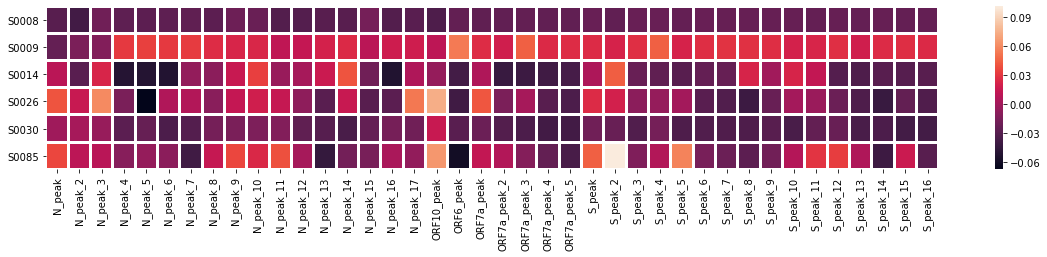

In [1659]:
res = read_data(big_df, total, n_sam=len(Samples)*2, norm='l1')
res_df = pd.DataFrame(data=res, columns=Samples, index=Peak_names)

data = res_df[['S0008','S0009','S0014','S0026','S0030','S0085']].T

h = draw_heatmap(data, sig_labels, borders=False)

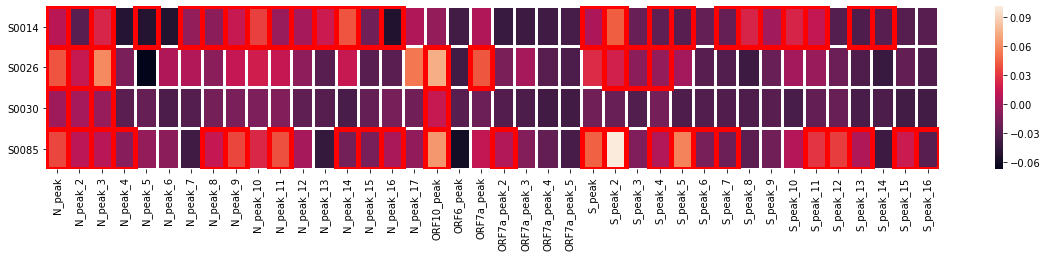

In [1658]:
# final result
res = read_data(big_df, total, n_sam=len(Samples)*2, norm='l1')
res_df = pd.DataFrame(data=res, columns=Samples, index=Peak_names)

# subset data for samples with ct < 18
data = res_df[['S0014','S0026','S0030','S0085']].T

h = draw_heatmap(data, sig_labels)

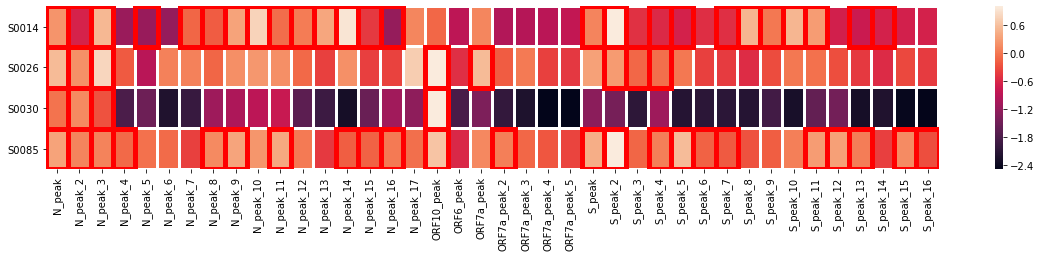

In [1662]:
res = read_data(big_df, total, n_sam=len(Samples)*2, norm='max')
res_df = pd.DataFrame(data=res, columns=Samples, index=Peak_names)

# subset data for samples with ct < 18
data = res_df[['S0014','S0026','S0030','S0085']].T

h = draw_heatmap(data, sig_labels, borders=True)

In [1562]:
cat _sh/exompeak.virus.R


library(GenomicFeatures)
library(exomePeak)

args <- commandArgs(trailingOnly = TRUE)

jobID  <- args[1]
OUTPUT <- args[2]
Sample <- args[3]
INPUT <- args[4]
IP <- args[5]

GTF = '~/Projects/COVID19_m6A/virus/coronavirus_2_isolate_Wuhan-Hu-1.gff3'

######################################## read meta ######################################$


IP_BAM = paste(Sample, IP, '.bam', sep='')
INPUT_BAM = paste(Sample, INPUT, '.bam', sep='')

print (IP_BAM)
print (INPUT_BAM)
print (OUTPUT)
######################################## functions ######################################
txdb <- makeTxDbFromGFF(GTF, organism=NA )

setwd(jobID)
print (txdb)

run_exomepeak <- function(    WINDOW = 15, STEP = 5, LENGTH = 15, FDR = 0.025, ENRICH = 0.2){
    res <- exomepeak(
        TXDB = txdb,
        IP_BAM=IP_BAM,
        INPUT_BAM=INPUT_BAM,
        OUTPUT_DIR=OUTPUT,
        EXPERIMENT_NAME=Sample,
        # options
        WINDOW_WIDTH = WINDOW,
        SLIDING_STEP = STEP,
        FRAGMENT_LENGTH = LEN

In [1563]:
cat _sh/pipeline.sh

###################### pre processing #############################
conda activate deseq 

mkdir -p trim
for fq in fastq/S00*R2*; do
	fq=`basename $fq`;
	out=${fq/_001.fastq.gz/.trim.fastq.gz};
	echo -------------------------$fq------------------------
	cutadapt -j 12 -u 3 -o trim/$out fastq/$fq
done

# map to human genome 
mkdir -p bam

STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/genomes/hg38/

for fq in fastq/*_R1*; do
	fq1=`basename $fq`;
	fq2=${fq1/R1_001.fastq.gz/R2.trim.fastq.gz};
	out=${fq1/R1_001.fastq.gz/};
	STAR \
	--outSAMtype BAM SortedByCoordinate \
	--readFilesCommand zcat \
	--runThreadN 16 \
	--genomeDir /rumi/shams/genomes/hg38/ \
	--readFilesIn fastq/$fq1 trim/$fq2 \
	--outFileNamePrefix bam/$out \
	--outReadsUnmapped Fastx;
done

STAR --genomeLoad Remove --genomeDir /rumi/shams/genomes/hg38/
rm Aligned.out.sam Log*out
rm -r bam/Undetermined_S0*

mkdir -p virus_fastq
mv bam/*_Unmapped.out.mate[1-2] virus_fastq/

mkdir -p qc_star/
mkdir -p qc_star/hg38

mv -v